# Figure 10: 

Evolution of the spatially integrated difference potential enstrophy tendency and contributions from individual processes diagnosed from the r.h.s. of Eq.7. The analysis is performed around the tropopause on the 326 K isentrope. Panel (b) further decomposes the diabatic contribution into the contributions from individual diabatic processes.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
# Loading libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
import xarray as xr
import colorlegend
from matplotlib import ticker

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading derived dataset from part 02

In [3]:
# loading datasets

# simulations
res = ['02_03']
#-------------------------------------
def load_simulations():
    
    ds_list = []
    for sim in list(res): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/pverrorgrowth/'
   
        # model output 'pv_icon' used for calculation
        fname1 = path+'pverror_diag_1x1_'+sim+'.nc'
        ds_var1 = xr.open_dataset(fname1)
        ds_var1.attrs['res'] = sim
        ds_list.append(ds_var1)
                  
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for 02_03


## 3- Helper functions

In [4]:
# functions

# gradient (center difference)
def grad(var,delta,ax):
    
    df = np.gradient(var,delta,axis=ax)
    
    return(df)

# forward difference
def obs_fd(ds):
    if ds.attrs['res'] == 'native':
        obs_fd = np.zeros((ds.time.size,ds.ncells.size)) * np.nan
    else:
        obs_fd = np.zeros((ds.time.size,ds.lev.size,ds.lat.size,ds.lon.size)) * np.nan
    for t in range(len(ds.time)-1):
        obs_fd[t] = (ds.dpe[t+1] - ds.dpe[t])/3600 
        
    obs_fd[-1] =  (ds.dpe[-1] - ds.dpe[-2])/3600 
    
    if ds.attrs['res'] == 'native':
        obs_fd_da = xr.DataArray(obs_fd, dims=('time','ncells'))
    else:
        obs_fd_da = xr.DataArray(obs_fd, dims=('time','lev','lat','lon'))
    
    return(obs_fd_da)

# center difference
def obs_cd(ds):

    obs_cd_np = grad(ds.dpe,3600,0) # 1 hourly output
    if ds.attrs['res'] == 'native':
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','ncells'))
    else:    
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','lev','lat','lon'))
    
    return(obs_cd_np_da)

# spatiall-integral for a slab of isentropes
def spin(ds,var,lev1,lev2):

    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(ds.lat), len(ds.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    #vertical sum
    si = (ds[var].sel(lev=slice(lev1,lev2)).sum('lev')*dA[None,:,:]).sum(axis=(1,2))
    return(si)

# spatial-integral just for 1 level
def spin2(ds,var,lev1):

    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(ds.lat), len(ds.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    #vertical sum
    si = (ds[var].sel(lev=lev1)*dA[None,:,:]).sum(axis=(1,2))
    return(si)

In [5]:
# common variables
lat  = ds_list[0].lat.values
lon  = ds_list[0].lon.values
time = ds_list[0].time
lev  = ds_list[0].lev

# deriving left hand side of the equation
ds_list[0]['ddtpv_ens'] = ds_list[0]['dpe'].diff(dim='time', label='upper')/3600
# or
ds_list[0]['ddtpv_ens_cd'] = obs_cd(ds_list[0])

## 4- Plot

In [6]:
# time series
pver_1x1 = {}

for var in ['ddtrhs','ddtrot','ddtdiv','ddtdia','ddtrad','ddtgsp','ddtmph','ddtcon',
            'ddtturb','ddtdrag','ddtdiff','ddtmom','ddtpv_ens_cd','dpe']:
    
    #pver_1x1[var] = spin(ds_list[0],var,320,330)
    pver_1x1[var] = spin2(ds_list[0],var,326)

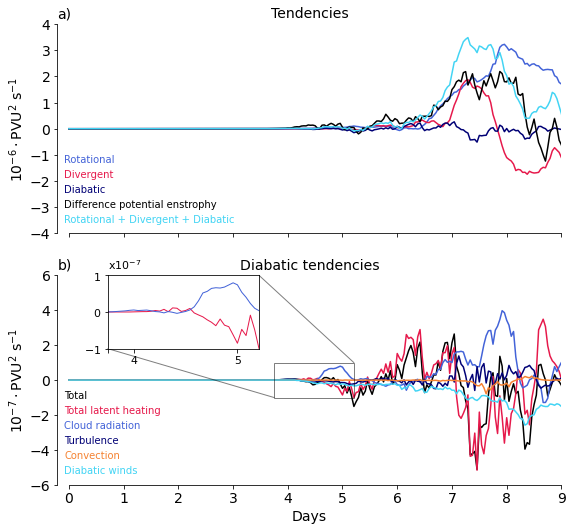

In [11]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
xaxis = np.arange(0,217,1)

i = 0

for ax in axes.flat:
    
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_bounds(0,216)
    ax.set_xticks(np.arange(0,217,24))
    ax.set_xticklabels(["0","1", "2", "3", "4", "5","6","7","8","9"])
    ax.tick_params(labelsize=14)
    ax.set_xlim([-5, 216])
    
    if i == 0:
        
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        
        im = ax.plot(pver_1x1['ddtrot']*(1e6**2)*1e6,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtdiv']*(1e6**2)*1e6,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtdia']*(1e6**2)*1e6,'#000075',label="Diabatic",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtpv_ens_cd']*(1e6**2)*1e6,'#000000',label="Difference potential enstrophy",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtrhs']*(1e6**2)*1e6,'#42d4f4',label="Rotational + Divergent + Diabatic",linewidth=1.5)
        
        ax.set_title('Tendencies',fontsize=14) 
        lg=colorlegend.color_legend(ax,loc=3,fsize=10)
        ax.set_ylabel('$10^{-6} \cdot $PVU$^2$ s$^{-1}$',fontsize=14)
        
        ax.set_xticklabels([])
        
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=14)
        
        ax.spines['left'].set_bounds(-4,4)
        ax.set_yticks(np.arange(-4,5,1))
        ax.set_ylim([-4,4])

    elif i == 1:
        
        im = ax.plot(pver_1x1['ddtdia']*(1e6**2)*1e7,'#000000',label="Total",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtmph']*(1e6**2)*1e7,'#e6194B',label="Total latent heating",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtrad']*(1e6**2)*1e7,'#4363d8',label="Cloud radiation",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtturb']*(1e6**2)*1e7,'#000075',label="Turbulence",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtcon']*(1e6**2)*1e7,'#f58231',label="Convection",linewidth=1.5)
        im = ax.plot(pver_1x1['ddtmom']*(1e6**2)*1e7,'#42d4f4',label="Diabatic winds",linewidth=1.5)
       
        ax.set_title('Diabatic tendencies',fontsize=14) 
        ax.legend(prop={'size': 10}, frameon=False)
        lg=colorlegend.color_legend(ax,loc=3,fsize=10)
        ax.set_ylabel('$10^{-7} \cdot $PVU$^2$ s$^{-1}$',fontsize=14)
        ax.set_xlabel('Days',fontsize=14)
        
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=14)
        
        ax.spines['left'].set_bounds(-6,6)
        ax.set_yticks(np.arange(-6,8,2))
        ax.set_ylim([-6,6])
        
        # inset axes....
        axins = ax.inset_axes([0.1, 0.65, 0.3, 0.35])
        axins.plot(pver_1x1['ddtmph']*(1e6**2)*1e7,'#e6194B',label="Total latent heating",linewidth=1)
        axins.plot(pver_1x1['ddtrad']*(1e6**2)*1e7,'#4363d8',label="Cloud radiation",linewidth=1)

        # sub region of the original image
        x1, x2, y1, y2 = 90, 125, -1, 1
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.spines['bottom'].set_bounds(90,125)
        axins.set_xticks([90,96,120])
        axins.set_xticklabels(["","4","5"])
        
        axins.tick_params(labelsize=11)
        axins.yaxis.set_major_formatter(formatter)
        axins.set_title('x10$^{-7}$',fontsize=11,loc='left')
        ax.indicate_inset_zoom(axins, edgecolor="black")

    i = i + 1     

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)   

plt.savefig('figure10.pdf', bbox_inches = 'tight')
plt.savefig('figure10.png', bbox_inches = 'tight',dpi=100)